- Author: Peter Steiglechner
- Date: January 2025

> **The core idea**: Using data from the ESS about Germans' climate change opinions in 2016, 2021 and 2023 to estimate subjective actual and perceived opinion polarisation based on social identities. This notebook analyses the data using the method described in the paper and visualises the results. For readability, we provide very simple visualisations capturing the core idea and later provide code to reproduce the figures in the manuscript:
> - relative mean disagreement from an objective viewpoint and from subjective ones with fixed or instantaneoulsy adjusted lenses.  
> - relative mean disagreement as above for each identity group.



In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix
import seaborn as sns

sns.set_style("ticks", {"axes.linewidth":0.5})
smallfs = 7
bigfs = 9
plt.rc('font', family = 'sans-serif')
plt.rc('font', size=smallfs)          # Ticklabels, legend labels, etc.
plt.rc('axes', labelsize=bigfs)    # Axis labels
plt.rc('axes', titlesize=bigfs)    # Titles

In [2]:
# Helper functions are defined in the accompanied file functions.py 
 
from functions import inferSubjectiveLenses, calc_meanObjectiveDisagreement, calc_meanPerceivedDisagreement, calc_meanPerceivedDisagreement_betweenGroups


In [3]:
prtcl_dict = {8: "prtclede", 10:"prtclfde", 11:"prtclgde"}

columns = ["essround", "anweight", "cntry"] + ["ccnthum", "wrclmch"] + ["prtdgcl"]+ list(prtcl_dict.values())

data = pd.read_csv(f"inputdata/ESS-subset.csv", usecols=columns)
data.essround.value_counts()

essround
10    8725
8     2852
11    2420
Name: count, dtype: int64

# Curate data

1. define partisan identities for each individual as the party that they feel closest to (and at least closer than "not at all close").
2. remove individuals with NaN values in the opinion data and the identity column
  

In [4]:
# 1. Identity
# 
party_dict = {
    1: "Union",
    2: "SPD",
    3: "Left Party",
    4: "Greens", 
    5: "FDP",
    6: "AfD"
}
for p in [7,8,9, 55, 77, 99]:
    party_dict[p] = np.nan  # individuals who feel close to other parties or refuse
for p in [66,88]:
    party_dict[p] = "None"   # individuals who do not feel close to any party.

for wave, prtcl in prtcl_dict.items():
    data.loc[data.essround==wave, "identity"] = data.loc[data.essround==wave][prtcl].replace(party_dict)
data.loc[(~data.identity.isna()) & (data.prtdgcl>3),"identity"] = "None"   # put individuals who feel "not at all close" to the stated party into non-partisan group

# 2. remove nan

variables_na = {"ccnthum": [55, 66, 77, 88, 99], "wrclmch": [6, 7, 8, 9]} 

for var, na_vals in variables_na.items():
    data[var] = data[var].replace(na_vals, np.nan)

# final dataset
    
data = data.dropna(subset=["identity"]+["ccnthum", "wrclmch"], how="any", axis="index")

data.essround.value_counts()

essround
10    7807
8     2681
11    2295
Name: count, dtype: int64

# Infer Lens


In [5]:
parties = ["Left Party", "Greens", "SPD", "None", "FDP", "Union", "AfD"] 

variables = ["ccnthum", "wrclmch"]

waves = [8,10, 11]

Lenses_81011 = inferSubjectiveLenses(data, parties=parties, waves=waves, variables=variables)


# Perceived Polarisation 

In [6]:

meanD = calc_meanPerceivedDisagreement(data, waves=waves, variables=variables, Lenses=Lenses_81011)

meanObjD = calc_meanObjectiveDisagreement(data, waves=waves, variables=variables)


In [7]:
print("8: ", meanD[8]) 
print("10: ", meanD[10]) 
print("11: ", meanD[11]) 
print("objective: ", meanObjD )

8:  {8: 1.7269330281370197}
10:  {8: 1.790299328864337, 10: 1.82120659113873}
11:  {8: 1.9034712307013462, 10: 1.9476156554068356, 11: 1.833451097629862}
objective:  {8: 1.3181992786517036, 10: 1.3931952037187567, 11: 1.4682114719545543}


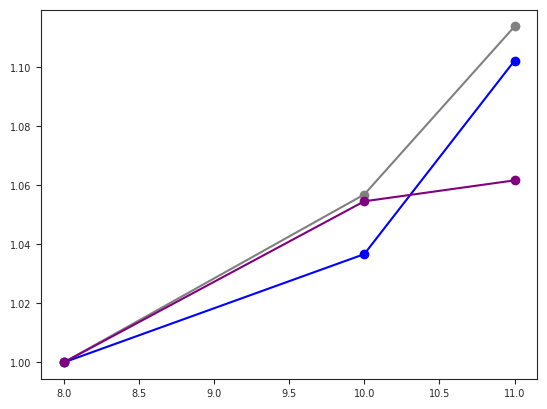

In [8]:
t0 = waves[0]
plt.plot(waves, [meanObjD[k]/meanObjD[t0] for k in waves], "-o", color="grey", label="objective")
plt.plot(waves, [meanD[k][t0]/meanD[t0][t0] for k in waves], "-o", color="blue", label="perceived,\nfixed lenses")
plt.plot(waves, [meanD[k][k]/meanD[t0][t0] for k in waves], "-o", color="purple", label="perceived,\ninstantaneously\nadjusted lenses")


# Perceived Polarisation between groups

In [9]:
PxA_meanDist_df, PxP_meanDist_df = calc_meanPerceivedDisagreement_betweenGroups(data, waves, parties, variables, Lenses_81011)

Left Party
wave 8  --> done (0 seconds, n=151)
wave 10  --> done (0 seconds, n=314)
wave 11  --> done (0 seconds, n=57)
Greens
wave 8  --> done (0 seconds, n=219)
wave 10  --> done (1 seconds, n=950)
wave 11  --> done (0 seconds, n=289)
SPD
wave 8  --> done (0 seconds, n=392)
wave 10  --> done (1 seconds, n=967)
wave 11  --> done (0 seconds, n=231)
None
wave 8  --> done (0 seconds, n=1286)
wave 10  --> done (2 seconds, n=4017)
wave 11  --> done (0 seconds, n=1262)
FDP
wave 8  --> done (0 seconds, n=52)
wave 10  --> done (0 seconds, n=395)
wave 11  --> done (0 seconds, n=53)
Union
wave 8  --> done (0 seconds, n=484)
wave 10  --> done (1 seconds, n=990)
wave 11  --> done (0 seconds, n=303)
AfD
wave 8  --> done (0 seconds, n=97)
wave 10  --> done (0 seconds, n=174)
wave 11  --> done (0 seconds, n=100)


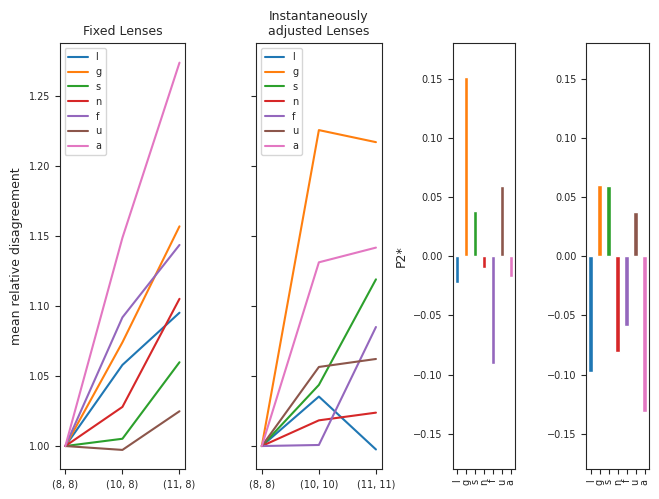

In [10]:
fig, axs= plt.subplots(1,4, gridspec_kw={"width_ratios":[1,1,0.5,0.5]})

combinationsFixed = [(8,8), (10,8), ((11),(8))]
relDist_PxA_fixed = (PxA_meanDist_df[combinationsFixed].T / PxA_meanDist_df[combinationsFixed].T.iloc[0] )
relDist_PxA_fixed.plot(ax=axs[0])

axs[0].set_title("Fixed Lenses")

combinationsInstAdj = [(8,8), (10,10), ((11),(11))]
relDist_PxA_adj = (PxA_meanDist_df[combinationsInstAdj].T / PxA_meanDist_df[combinationsInstAdj].T.iloc[0] )
relDist_PxA_adj.plot(ax=axs[1])

axs[1].set_title("Instantaneously\nadjusted Lenses")
axs[1].sharey(axs[0])
axs[0].set_ylabel("mean relative disagreement")

p2 = (relDist_PxA_adj.reset_index()[relDist_PxA_adj.columns] - relDist_PxA_fixed.reset_index()[relDist_PxA_fixed.columns])
p2["wave"] = waves
p2 = p2.set_index("wave")

p2.loc[10].plot.bar(ax=axs[2], color=[plt.get_cmap("tab10")(n) for n in range(10)])
p2.loc[11].plot.bar(ax=axs[3], color=[plt.get_cmap("tab10")(n) for n in range(10)])
axs[2].set_ylim(-0.18, 0.18)
axs[3].sharey(axs[2])
axs[2].set_ylabel("P2*")

fig.tight_layout(pad=0.05)


# Fancy Plots

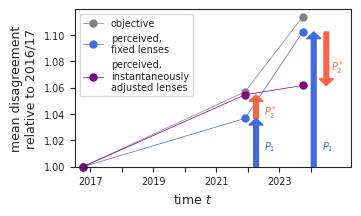

In [11]:
t0 = waves[0]

d_obj_arr = np.array([meanObjD[k] for k in waves])/meanObjD[t0]
d_opOnly = np.array( [meanD[k][t0] for k in waves])/meanD[t0][t0]
d_tot =  np.array( [meanD[k][k] for k in waves])/meanD[t0][t0]

linecols = {"obj":"grey", "fixed":"royalblue", "adapt":"purple", "P2":"tomato"}
years = [2016+9.2/12, 2021+11/12, 2023+9/12]
fig = plt.figure(figsize=(8.9/2.54, 5/2.54))
ax = plt.axes()
ax.set_clip_on(True)
ax.plot(years, d_obj_arr, "-o", color=linecols["obj"], label="objective", lw=0.5, markersize=5, clip_on=False)
ax.plot(years, d_opOnly, "-o", color=linecols["fixed"], label="perceived,\nfixed lenses", lw=0.5, markersize=5, clip_on=False)
ax.plot(years, d_tot, "-o", color=linecols["adapt"], label="perceived,\ninstantaneously\nadjusted lenses", lw=0.5, markersize=5, clip_on=False)
for y, dtot, dopOnly in zip(years[1:], d_tot[1:], d_opOnly[1:]):
    ax.arrow(0.35+y+0.4*(y==years[2]), dopOnly, 0, dtot-dopOnly, color=linecols["P2"], length_includes_head=True,width=0.15,head_length=0.005, zorder=5)
    ax.arrow(0.35+y,1,0, dopOnly-1, color=linecols["fixed"], length_includes_head=True,width=0.15,head_length=0.005, zorder=5)
s = r"$P_2^*$"#+"instantanous lens-specific polarisation w.r.t. 2016/17"
ax.text(years[-1]+0.9, dopOnly-0.02, s, color=linecols["P2"], va="top", ha="left", fontsize=smallfs)
ax.text(years[1]+0.6, 1.035, s, color=linecols["P2"], va="bottom", ha="left", fontsize=smallfs)
s = r"$P_1$"
ax.text(years[-1]+0.6, 1.01, s, color=linecols["fixed"], ha="left", va="bottom", fontsize=smallfs)
ax.text(years[1]+0.6, 1.01, s, color=linecols["fixed"], va="bottom", ha="left", fontsize=smallfs)
ax.legend(loc="upper left", fontsize=smallfs)
ax.set_ylabel("mean disagreement\n"+r"relative to 2016/17", fontsize=bigfs)
ax.set_xlim(2016.5,2025.3)
ax.set_xticks(range(2017, 2025))
ax.set_xticklabels([k if k%2==1 else "" for k in ax.get_xticks()])
ax.set_xlabel(r"time $t$", fontsize=bigfs, x=0.5*(2024-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
ax.set_ylim(1,)
fig.subplots_adjust(top=0.98, right=0.98, left=0.19, bottom=0.18)
plt.savefig("figs/disagreement_over_time.png", dpi=600)
plt.savefig("figs/disagreement_over_time.pdf")

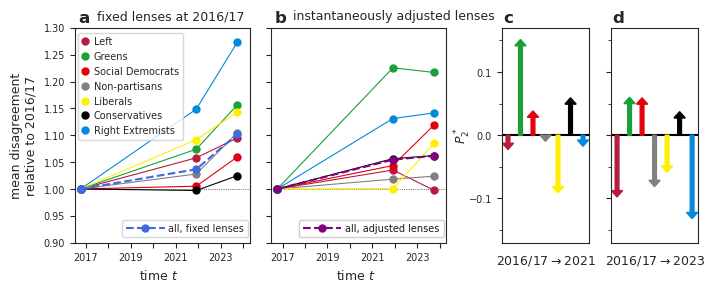

In [14]:
kuerzel2party = {"u":"Union", "s":"SPD", "l":"Left Party", "g":"Greens", "f":"FDP", "a":"AfD", "n":"None"}

kuerzel2group = {'u': 'Conservatives',
 's': 'Social Democrats',
 'l': 'Left',
 'g': 'Greens',
 'f': 'Liberals',
 'a': 'Right Extremists',
 'n': 'Non-partisans'}

colors = dict(zip(["Union", "SPD", "Left Party", "Greens", "FDP", "AfD", "None"], ["#000000", "#E3000F", "#b61c3e", "#1AA037", "#FFEF00", "#0489DB", "grey"]))  # 


combinationsFixed = [(8,8), (10,8), ((11),(8))]
combinationsInstAdj = [(8,8), (10,10), ((11),(11))]

relDist_PxA_fixed = PxA_meanDist_df[combinationsFixed].T / PxA_meanDist_df[combinationsFixed].T.loc[combinationsFixed[0]]

relDist_PxA_adj = PxA_meanDist_df[combinationsInstAdj].T / PxA_meanDist_df[combinationsInstAdj].T.loc[combinationsInstAdj[0]]

years = [2016+9.2/12, 2021+11/12, 2023+9/12]
fig, axs = plt.subplot_mosaic([["fixedPerc", "changPerc", "empty", "P*10", "P*11"]], figsize=(17.8/2.54, 7/2.54), width_ratios=[1,1,0.07,0.5,0.5])
axs["empty"].axis("off")
for axN, d, dall, title in zip(["fixedPerc", "changPerc"], [relDist_PxA_fixed, relDist_PxA_adj], [d_opOnly, d_tot],[r"fixed lenses at 2016/17", r"instantaneously adjusted lenses"]):
    ax = axs[axN]
    ax.set_clip_on(True)
    
    for p in d.columns:
        ax.plot(years, d[p], "-o", color=colors[kuerzel2party[p]], lw=0.8,markersize=5, label=kuerzel2group[p])
    

    ax.plot(years, dall, "--o", color=linecols["fixed"]if axN=="fixedPerc" else linecols["adapt"], label="all", lw=1.5, markersize=5, zorder=20)

    ax.set_xlim(2016.5,2024.3)
    ax.set_xticks(range(2017, 2025))
    ax.set_xticklabels([k if k%2==1 else "" for k in ax.get_xticks()])
    ax.set_xlabel(r"time $t$", fontsize=bigfs, x=0.5*(2024-ax.get_xlim()[0])/(ax.get_xlim()[1]-ax.get_xlim()[0]))
    ax.hlines(1,2016.5, 2024.3, colors="k", zorder=0, lw=0.5, linestyles=":")
    ax.set_ylim(0.9, 1.3)
    ax.set_title(title, fontsize=bigfs, x=0.55 if ax==axs["fixedPerc"] else 0.7)
    
ax = axs["changPerc"]
ax.set_yticklabels([])

# In total 3x3 lines have been plotted
lines = axs["fixedPerc"].get_lines()
legend1 = axs["fixedPerc"].legend([lines[i] for i in range(len(lines[:-1]))], [lines[i].get_label() for i in range(len(lines[:-1]))], loc="upper center", fontsize=smallfs, ncol=1, columnspacing=0.7, bbox_to_anchor=(0.32, 1), handlelength=0.6, borderpad=0.4,handletextpad=0.6,)
axs["fixedPerc"].add_artist(legend1)
legend2 = axs["fixedPerc"].legend([lines[-1]], ["all, fixed lenses"], loc="upper center", fontsize=smallfs, ncol=1, columnspacing=0.7, borderpad=0.4,handletextpad=0.4, handlelength=4, bbox_to_anchor=(0.63, 0.13))
lines = axs["changPerc"].get_lines()
legend3 = axs["changPerc"].legend([lines[-1]], ["all, adjusted lenses"], loc="upper center", fontsize=smallfs, ncol=1, columnspacing=0.7, handlelength=4, bbox_to_anchor=(0.57, 0.13),borderpad=0.4,handletextpad=0.4,)
axs["changPerc"].add_artist(legend3)

axs["fixedPerc"].set_ylabel(r"mean disagreement"+"\n"+r"relative to 2016/17", fontsize=bigfs)


p2 = (relDist_PxA_adj.reset_index()[relDist_PxA_adj.columns] - relDist_PxA_fixed.reset_index()[relDist_PxA_fixed.columns])
p2["wave"] = waves
p2 = p2.set_index("wave")

for axN, p2_t, y in zip(["P*10", "P*11"], [p2.loc[10], p2.loc[11]], [2021, 2023]):
    ax = axs[axN]
    ax.set_xlabel(rf"{2016}/{17}$\rightarrow${y}",fontsize=bigfs)
    for n, (p) in enumerate(p2.columns):
        ax.arrow(n, 0, 0, p2_t[p], width=0.3, head_length=0.01, length_includes_head=True, color=colors[kuerzel2party[p]])
    ax.set_ylim(-0.17, 0.17)    
    ax.set_xticks([])
    ax.set_xlim(-0.5, 6.5)
    ax.set_yticks(np.arange(-0.15, 0.16, 0.05), minor=True)
    ax.set_yticks(np.arange(-0.1, 0.11, 0.1), minor=False)
    ax.hlines(0,-0.5,6.5, color="k", zorder=-1)
axs["P*10"].set_ylabel(r"$P^*_2$", labelpad=-3)#+"\n", x=1.1)
axs["P*11"].set_yticklabels([])
    
letters = ["a", "b", "c", "d", "e", "f"]
for l, axN in enumerate(["fixedPerc", "changPerc", "P*10", "P*11"]):
    ax = axs[axN]    
    ax.text(0.02, 1.01, letters[l], va="bottom", ha="left", fontdict={"weight":"bold", "size":12}, transform=ax.transAxes, zorder=20)


fig.subplots_adjust(top=0.92, right=0.99, left=0.1, bottom=0.14)
#fig.set_facecolor("y")
plt.savefig("figs/disagreement_over_time_byParty.png", dpi=600)
plt.savefig("figs/disagreement_over_time_byParty.pdf")
